<a href="https://colab.research.google.com/github/William171409/FN6809/blob/main/FN6808.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FN6808 Derivative Securities Project
Group 12 Members: <br>
HU ZIHAO <br>
NI SHANG <br>
CHEN JIAYI <br>
SHI XUEER <br>

In [ ]:
!pip install pandas-market-calendars
!pip install arch

In [ ]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.stats import norm

import time
from datetime import datetime
from datetime import timedelta

from scipy.interpolate import make_interp_spline

import pandas_market_calendars as mcal

## 1. Modeling volatility
Since Apple stock a publicly traded equity, we select it as our target equity in the project. The 3 years price data is downloaded from Yahoo Finance through yfinance package.

In [ ]:
data = yf.download("AAPL", start="2021-10-15", end = "2024-10-14")  #Use data from 2021.10.15 to 2024.10.14
data['Return'] = np.log(1 + data['Adj Close'].pct_change())
data = data.iloc[1:].reset_index(drop=True)
data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
0,144.136368,146.550003,146.839996,143.160004,143.449997,85589200,0.011737
1,146.309967,148.759995,149.169998,146.550003,147.009995,76378900,0.014968
2,146.801743,149.259995,149.750000,148.119995,148.699997,58418800,0.003356
3,147.018127,149.479996,149.639999,147.869995,148.809998,61421000,0.001473
4,146.241119,148.690002,150.179993,148.639999,149.690002,58883400,-0.005299
...,...,...,...,...,...,...,...
746,221.690002,221.690002,225.690002,221.330002,224.500000,39505400,-0.022789
747,225.770004,225.770004,225.979996,223.250000,224.300003,31855700,0.018237
748,229.539993,229.539993,229.750000,224.830002,225.229996,33591100,0.016560


### 1.1 GBM
We want to fit the historical data to Geometric Brownian Motion, first of all we need to find the initial price S0

In [ ]:
S0 = data['Adj Close'].iloc[0]
S0

,0
Ticker,
AAPL,144.136368


After that, we use the GBM process, which is $dlns = (\mu - 1/2 * \sigma^2) * dt + \sigma * \sqrt T * Z $
to generate three GBM paths

In [ ]:
mu = data['Return'].mean()
sigma = data['Return'].std()
n = len(data)
dt = 1

def simulate_gbm(mu, sigma, S, dt, n):
    S_new = np.zeros(n)
    S_new[0] = S
    for t in range(1, n):
        dlns = (mu - 0.5 * sigma**2) * dt + sigma * np.random.normal(0, np.sqrt(dt))
        S_new[t] = S_new[t-1] * np.exp(dlns)
    return S_new

# simulate 3 GBM paths
df_simulated = data[['Adj Close']].copy()
for i in range(3):
    gbm = simulate_gbm(mu, sigma, S0, dt, n)
    df_simulated['GBM_{}'.format(i)] = gbm

df_simulated

<ipython-input-39-6c3c21f7cd86>:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S_new[0] = S
<ipython-input-39-6c3c21f7cd86>:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S_new[0] = S
<ipython-input-39-6c3c21f7cd86>:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S_new[0] = S


Price,Adj Close,GBM_0,GBM_1,GBM_2
Ticker,AAPL,,,
0,144.136368,144.136368,144.136368,144.136368
1,146.309967,147.602210,144.245631,142.812307
2,146.801743,145.545690,144.300518,147.321559
3,147.018127,148.068338,142.184888,146.516792
4,146.241119,149.146978,138.319700,150.466863
...,...,...,...,...
746,221.690002,289.103130,225.449486,251.697229
747,225.770004,276.268390,222.466070,248.764936
748,229.539993,275.449401,230.323294,245.351067


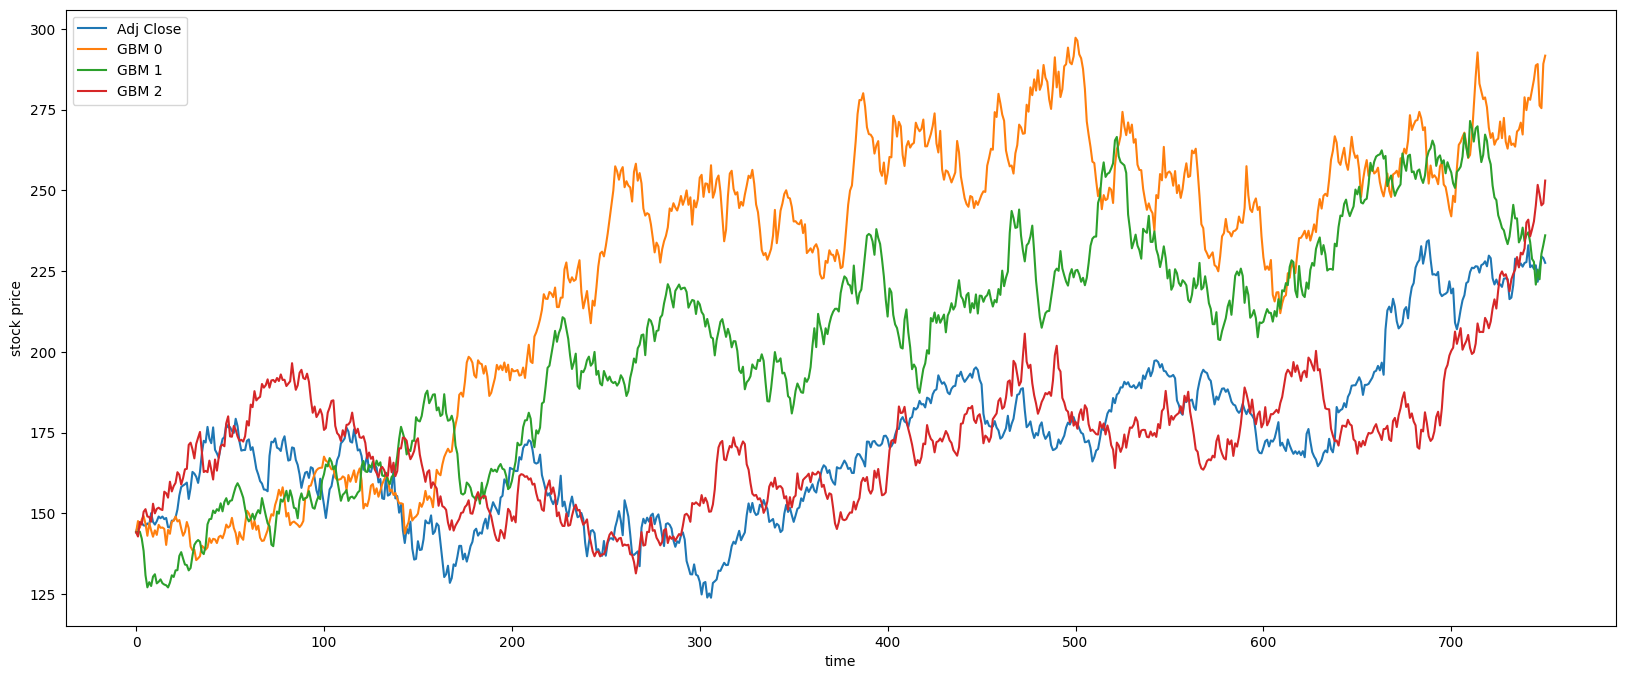

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df_simulated['Adj Close'], label='Adj Close')
plt.plot(df_simulated['GBM_0'], label='GBM 0')
plt.plot(df_simulated['GBM_1'], label='GBM 1')
plt.plot(df_simulated['GBM_2'], label='GBM 2')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

### 1.2 Any non-constant volatility model
Similarly, we use GARCH(1,1) model to estimate variance through arch package, in order to generate non-constant volatility model

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000301. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 4909263119385.281
Iteration:      2,   Func. Count:     18,   Neg. LLF: 30335916.011559345
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1104267386401.4753
Iteration:      4,   Func. Count:     46,   Neg. LLF: 5258045.319992082
Iteration:      5,   Func. Count:     59,   Neg. LLF: 122665316974.97998
Iteration:      6,   Func. Count:     72,   Neg. LLF: 35839680634.35539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2011.4846615852598
            Iterations: 6
            Function evaluations: 82
            Gradient evaluations: 6
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2011.48
Distribution:                  Normal   

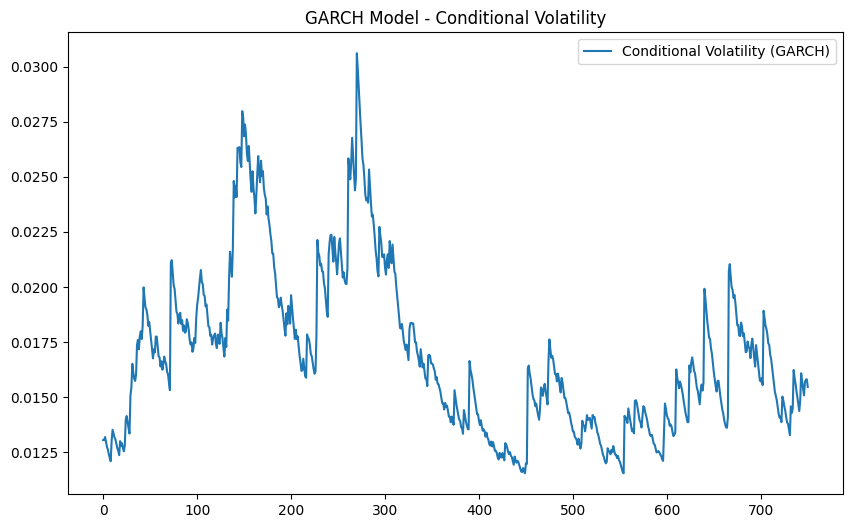

In [ ]:
model = arch_model(data['Return'].dropna(), vol='Garch', p=1, q=1)
garch_result = model.fit()

print(garch_result.summary())
garch_volatility = garch_result.conditional_volatility

plt.figure(figsize=(10, 6))
plt.plot(garch_volatility, label='Conditional Volatility (GARCH)')
plt.title('GARCH Model - Conditional Volatility')
plt.legend()
plt.show()

The model shows a log-likelihood of 2011.48, indicating a strong fit to the data. Both AIC (-4014.97) and BIC (-3996.48) are negative, suggesting a well-balanced model in terms of goodness-of-fit and complexity. The coefficients for the mean (0.001051) and GARCH (0.9300) parameters are statistically significant, with very low p-values, confirming their importance in the model. Despite the R-squared and Adjusted R-squared being close to zero, this is not critical in GARCH models, as they primarily model volatility rather than mean returns. Overall, the model appears robust based on these metrics.

In [ ]:
residuals = garch_result.resid
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_test

,lb_stat,lb_pvalue
10,8.288833,0.600647


The p-value of 0.60 from the Ljung-Box test indicates no significant autocorrelation in the residuals, suggesting the model has effectively captured the data's time series patterns and is performing well.

In [ ]:
def simulate_gbm2(mu, garch_volatility, S, dt, n):
    S_new = np.zeros(n)
    S_new[0] = S
    for t in range(1, n):
        dlns = (mu - 0.5 * garch_volatility[t]**2) * dt + garch_volatility[t] * np.random.normal(0, np.sqrt(dt))
        S_new[t] = S_new[t-1] * np.exp(dlns)
    return S_new

# simulate 3 paths
df_simulated2 = data[['Adj Close']].copy()
for i in range(3):
    gbm = simulate_gbm2(mu, garch_volatility, S0, dt, n)
    df_simulated2['GBM2_{}'.format(i)] = gbm

df_simulated2

<ipython-input-43-d7854ad57193>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S_new[0] = S
<ipython-input-43-d7854ad57193>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S_new[0] = S
<ipython-input-43-d7854ad57193>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S_new[0] = S


Price,Adj Close,GBM2_0,GBM2_1,GBM2_2
Ticker,AAPL,,,
0,144.136368,144.136368,144.136368,144.136368
1,146.309967,143.944977,145.043191,145.637341
2,146.801743,145.406942,141.601124,147.943597
3,147.018127,144.532911,141.001669,147.450932
4,146.241119,145.645234,142.010283,150.078244
...,...,...,...,...
746,221.690002,196.019075,156.484658,225.421493
747,225.770004,193.712206,159.213641,229.624628
748,229.539993,198.435236,159.413823,227.993348


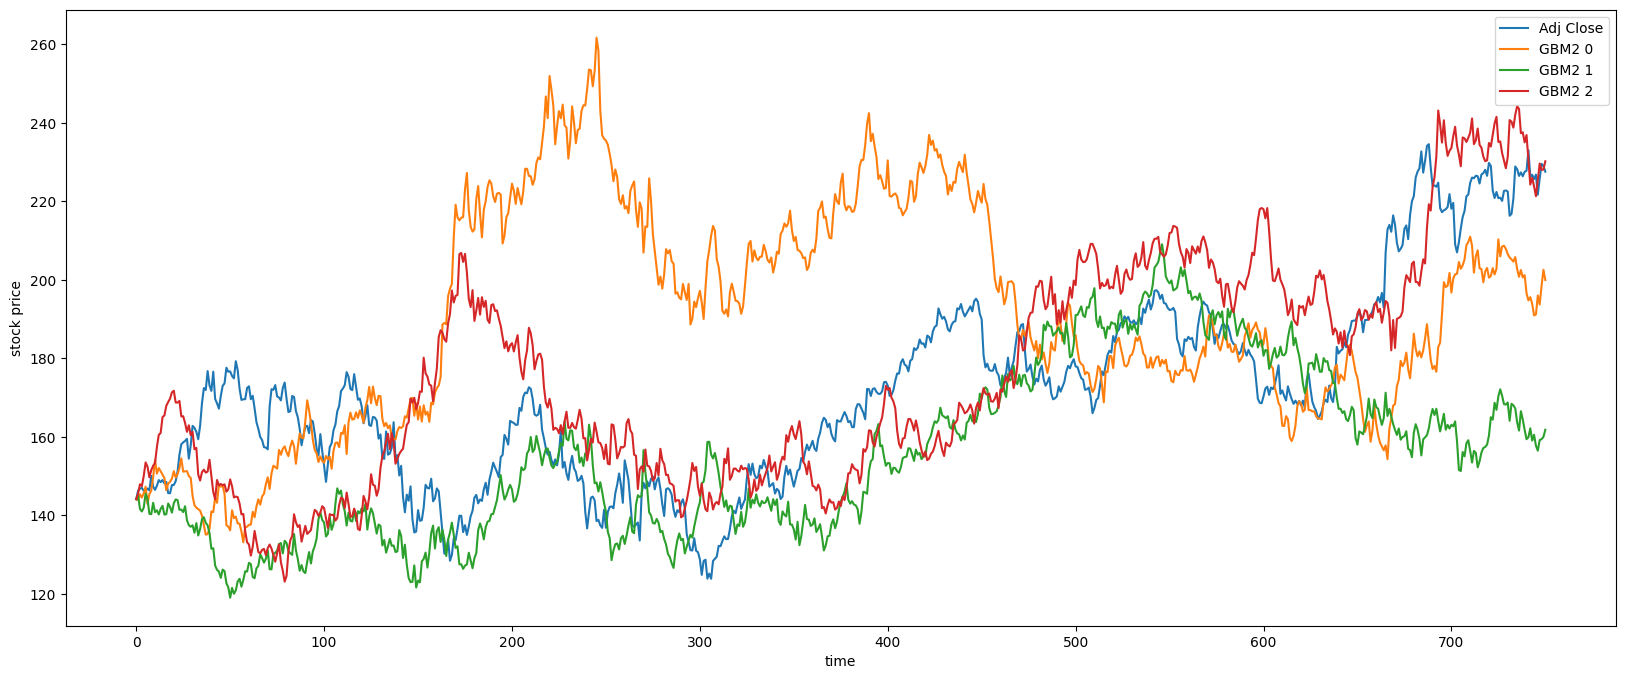

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df_simulated2['Adj Close'], label='Adj Close')
plt.plot(df_simulated2['GBM2_0'], label='GBM2 0')
plt.plot(df_simulated2['GBM2_1'], label='GBM2 1')
plt.plot(df_simulated2['GBM2_2'], label='GBM2 2')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

### 1.3 Volatility Smile


In this part, we focus on 'Out-of-the-Money' options (OTM) to proceed our analysis of implied volatility, including volatility smile, term structure, and volatility surface. Using OTM options help market traders better understand the market expectations for tail risks or speculative strategies. In contrast, including all option prices can provide a more comprehensive view of implied volatility across different market conditions. Generally, the choice between OTM options and All options depends on researchers' specific goal and the context of analysis.

We use historical data for AAPL periods from 2021.10.15 to 2024.10.14, to conduct the following analysis related to options.

In [ ]:
# Download historical data for AAPL
data = yf.download("AAPL", start="2021-10-15", end="2024-10-14")  # Use data from 2021.10.15 to 2024.10.14
data['Return'] = np.log(1 + data['Adj Close'].pct_change())
data = data.iloc[1:].reset_index(drop=True)

stock = yf.Ticker('AAPL')
options_dates = stock.options
options_dates

[*********************100%***********************]  1 of 1 completed


('2024-11-08',
 '2024-11-15',
 '2024-11-22',
 '2024-11-29',
 '2024-12-06',
 '2024-12-20',
 '2025-01-17',
 '2025-02-21',
 '2025-03-21',
 '2025-04-17',
 '2025-06-20',
 '2025-08-15',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18',
 '2027-01-15')

Select the current price data as *S*, we then use 'Out-of-the-Money' options (OTM) with the nearest expiration date to promote our analysis of volatility smile.

In [ ]:
# Select the nearest expiration date
expiration_date = options_dates[0]
option_chain = stock.option_chain(expiration_date)
calls = option_chain.calls
puts = option_chain.puts

S = float(data['Adj Close'].iloc[-1])  # Current stock price

# Get OTM options
calls_otm = calls[calls['strike'] > S]  # Call options with strike price > current price
puts_otm = puts[puts['strike'] < S]   # Put options with strike price < current price

# Combine OTM calls and puts into a single DataFrame
option_df = pd.concat([calls_otm[['strike', 'lastPrice']], puts_otm[['strike', 'lastPrice']]])
option_df.sort_values(by='strike', inplace=True)  # Order by strike price
print(option_df)

    strike  lastPrice
0    105.0       0.03
1    125.0       0.02
2    140.0       0.08
3    145.0       0.10
4    150.0       0.02
5    155.0       0.01
6    160.0       0.02
7    165.0       0.01
8    170.0       0.03
9    175.0       0.02
10   180.0       0.02
11   185.0       0.03
12   190.0       0.05
13   195.0       0.07
14   200.0       0.11
15   205.0       0.18
16   207.5       0.26
17   210.0       0.41
18   212.5       0.68
19   215.0       1.02
20   217.5       1.58
21   220.0       2.28
22   222.5       3.27
23   225.0       4.55
24   227.5       6.03
23   230.0       0.87
24   232.5       0.50
25   235.0       0.24
26   237.5       0.14
27   240.0       0.08
28   242.5       0.05
29   245.0       0.03
30   247.5       0.02
31   250.0       0.02
32   252.5       0.01
33   255.0       0.01
34   260.0       0.01
35   265.0       0.01
36   270.0       0.01
37   275.0       0.01
38   280.0       0.01
39   285.0       0.02
40   290.0       0.01
41   300.0       0.01


<ipython-input-46-39877a2db9d3>:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(data['Adj Close'].iloc[-1])  # Current stock price


We use 10-year American Treasury bond rate as the risk-free rate, which is 1.74%. With the Black-Scholes pricing model, we can obtain the implied volatility using the Brent algorithm---a root-finding algorithm
that combines the bisection method, the secant method, and inverse quadratic interpolation. Since we already know the maturity, risk-free rate, current stock price, and strike price, we can effectively apply this method.

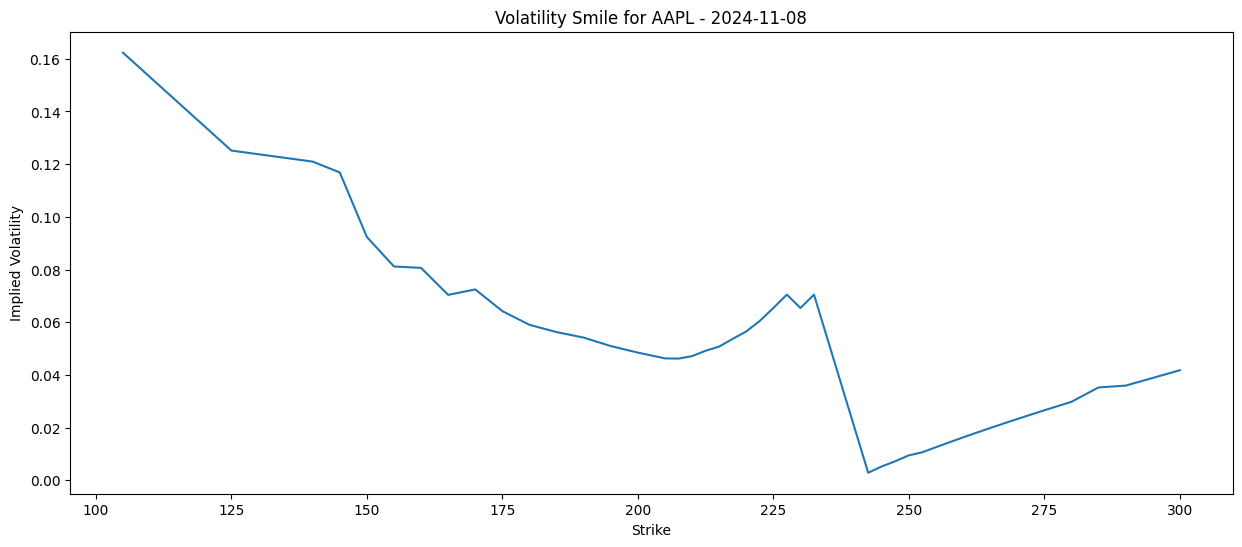

In [ ]:
# Set risk-free rate and time to expiration
r = 0.0174  # Select risk-free rate (5-year US Treasury bond)
date1 = datetime(2024, 10, 14)  # Current date
date2 = datetime(2027, 1, 15)   # Expiration date
T = (date2 - date1).days / 252    # Time to expiration in years

# Black-Scholes formulas
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_volatility(option_price, S, K, T, r):
    def objective_function_call(sigma):
        return black_scholes_call(S, K, T, r, sigma) - option_price

    def objective_function_put(sigma):
        return black_scholes_put(S, K, T, r, sigma) - option_price

    try:
        if K > S:
            return brentq(objective_function_call, 1e-5, 10, xtol=1e-6)
        else:
            return brentq(objective_function_put, 1e-5, 10, xtol=1e-6)
    except ValueError:
        return None

# Calculate implied volatility for OTM options
option_df['Implied Volatility'] = option_df.apply(
    lambda row: implied_volatility(row['lastPrice'], S, row['strike'], T, r), axis=1
)

# Plot volatility smile
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=option_df, ax=ax, x="strike", y="Implied Volatility")
ax.set(xlabel='Strike', ylabel='Implied Volatility')
ax.set_title(f'Volatility Smile for AAPL - {expiration_date}')
plt.show()

### 1.4 Term Structure of Volatility

The term structure of implied volatility refers to the pattern or shape of implied volatility levels for options with **different expiration dates** but with the same underlying asset. It provides insights into how market participants perceive the risk and potential price movements of the underlying asset over varying time horizons.

In this part, we use OTM options with a strike price of 250 as an example to construct the term structure of implied volatility. 'plot_iv_term_structure_otm' is defined to take a specific strike price as input and plot the term structure of implied volatility for the chosen option price.

The key logic in this user-defined-function involves iterating over different expiration dates. It first retrieves the option chain for the specified expiration date, and then calculates the number of days until expiration (denoted as *T_days*). Finally, it filters the calls and puts to find OTM options based on the current stock price *S*.   

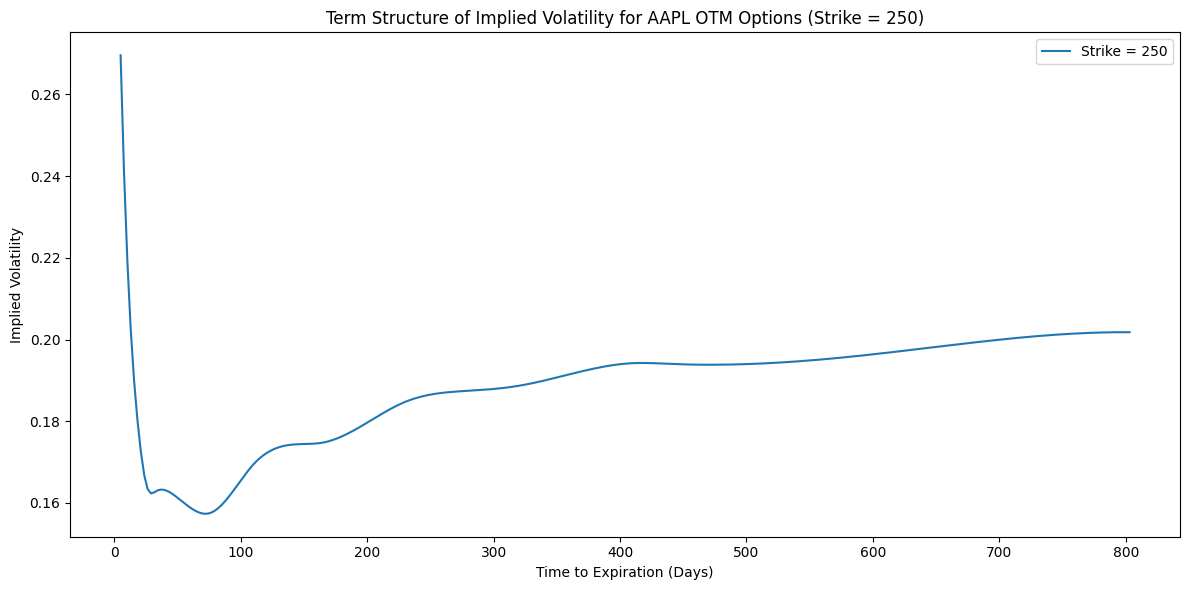

In [ ]:
# Function to plot the term structure of implied volatility for Out-of-the-Money (OTM) options
def plot_iv_term_structure_otm(strike_price):
    iv_data = []  # Initialize a list to store implied volatility data

    # Loop through each expiration date to gather data
    for expiration_date in options_dates:
        # Retrieve the option chain for the given expiration date
        option_chain = stock.option_chain(expiration_date)

        # Calculate time to expiration in days
        T_days = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days

        # Filter for OTM calls (strike price greater than current price) and OTM puts (strike price less than current price)
        calls_otm = option_chain.calls[option_chain.calls['strike'] > S]
        puts_otm = option_chain.puts[option_chain.puts['strike'] < S]

        # Combine the last price of the specified strike price for both OTM calls and puts
        option_df = pd.concat([
            calls_otm[calls_otm['strike'] == strike_price][['strike', 'lastPrice']],
            puts_otm[puts_otm['strike'] == strike_price][['strike', 'lastPrice']]
        ])

        # Calculate implied volatility for OTM options if option_df is not empty
        if not option_df.empty:
            option_df['Implied Volatility'] = option_df.apply(
                lambda row: implied_volatility(row['lastPrice'], S, row['strike'], T_days / 252, r), axis=1
            )

            # Append the calculated implied volatility to the iv_data list
            for _, row in option_df.iterrows():
                if not pd.isna(row['Implied Volatility']):
                    iv_data.append({
                        'Time to Expiration (Days)': T_days,
                        'Implied Volatility': row['Implied Volatility']
                    })

    # Convert the list to a DataFrame and average implied volatilities by expiration days to avoid duplicates
    iv_df = pd.DataFrame(iv_data).groupby('Time to Expiration (Days)', as_index=False)['Implied Volatility'].mean()

    # Create a plot for the implied volatility term structure
    plt.figure(figsize=(12, 6))  # Set the figure size
    x, y = iv_df['Time to Expiration (Days)'], iv_df['Implied Volatility']  # Define x and y for plotting

    # Smooth the curve if there are more than 2 points to enhance visualization
    if len(x) > 2:
        x_smooth = np.linspace(x.min(), x.max(), 300)  # Create a smooth range for x values
        spline = make_interp_spline(x, y, k=3)  # Create a spline interpolation
        y_smooth = spline(x_smooth)  # Calculate the corresponding y values for the smooth x range
        plt.plot(x_smooth, y_smooth, label=f'Strike = {strike_price}')  # Plot the smoothed line
    else:
        plt.plot(x, y, marker='o', linestyle='--', label=f'Strike = {strike_price}')  # Plot points for fewer data

    # Set plot title and labels
    plt.title(f'Term Structure of Implied Volatility for AAPL OTM Options (Strike = {strike_price})')
    plt.xlabel('Time to Expiration (Days)')
    plt.ylabel('Implied Volatility')
    plt.legend(loc='upper right')  # Place legend in the upper right corner
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Display the plot

# Call the function to plot the term structure for OTM options with a strike price of 250
plot_iv_term_structure_otm(strike_price=250)


### 1.5 Volatility Surface

The volatility surface is a 3D graphical representation of the implied volatility of options as a function of strike price and time to maturity (we use a function of time to maturity and moneyness in this session, where moneyness is defined as the strike price divided by the stock price). This surface visually depicts how implied volatility varies across different options, assisting quants in examining the market mispricings and any other analyses.

The data preprocessing is similar to that of volatility smile and term structure. Typically, the volatility surface of implied volatility is simply a combination of both charters.

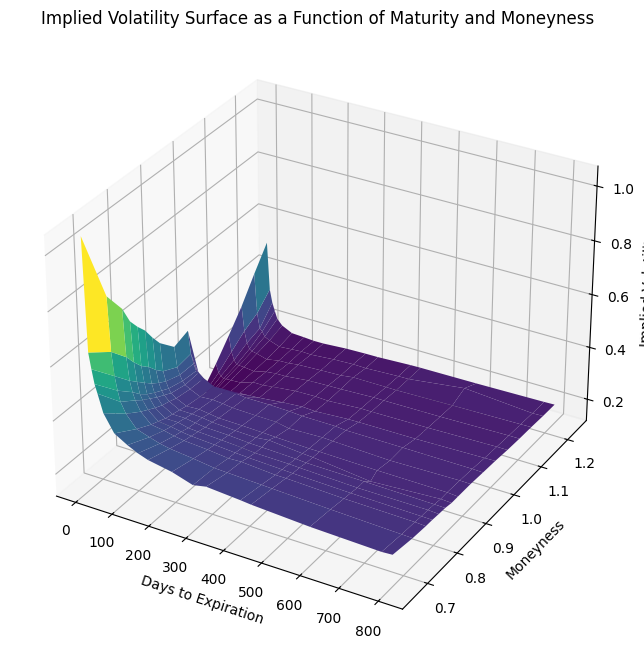

In [ ]:
# Implied volatility surface
iv_data = []  # Store implied volatilities for various strike prices and expiration dates

# Iterate over expiration dates and calculate implied volatility
for expiration_date in options_dates:
    option_chain = stock.option_chain(expiration_date)
    calls = option_chain.calls
    puts = option_chain.puts

    # Filter OTM calls and ITM puts
    calls_otm = calls[calls['strike'] > S]
    puts_otm = puts[puts['strike'] < S]

    # Combine calls and puts into a single DataFrame
    option_df = pd.concat([calls_otm[['strike', 'lastPrice']], puts_otm[['strike', 'lastPrice']]])
    option_df.sort_values(by='strike', inplace=True)

    # Calculate time to expiration in years
    T_days = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days / 252  # Convert days to years

    # Calculate implied volatilities for all strikes
    for _, row in option_df.iterrows():
        iv = implied_volatility(row['lastPrice'], S, row['strike'], T_days, r)
        if iv is not None:
            iv_data.append({
                'Expiration': expiration_date,
                'Strike Price': row['strike'],
                'Moneyness': row['strike'] / S,  # Calculate moneyness
                'Implied Volatility': iv,
                'Days to Expiration': (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days
            })

# Convert to DataFrame
iv_df = pd.DataFrame(iv_data)

# Pivot the DataFrame for plotting
surface = (
    iv_df.pivot_table(values='Implied Volatility', index='Moneyness', columns='Days to Expiration')
    .dropna()
)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get the grid for plotting
x = surface.columns.values  # Days to expiration
y = surface.index.values     # Moneyness
z = surface.values           # Implied volatilities

X, Y = np.meshgrid(x, y)

# Set labels
ax.set_xlabel('Days to Expiration')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface as a Function of Maturity and Moneyness')

# Plot the surface
ax.plot_surface(X, Y, z, cmap='viridis')
plt.show()

## 2. Vanilla European Option Pricing
We select an option price with strike = $200 and expire in about 1 calender year (expired date: 2025-09-19)

In [ ]:
nyse = mcal.get_calendar('NYSE')

In [ ]:
# Set today's date
today = datetime.now()
# today = datetime.strptime('2024-10-14','%Y-%m-%d')

# Calculate the target expiration date (approximately one year from today)
target_expiration_date = today + timedelta(days=365)

expiration_date = None
closest_date = None
for date in options_dates:
    expiration_date_candidate = datetime.strptime(date, '%Y-%m-%d')
    if closest_date is None or abs((expiration_date_candidate - target_expiration_date).days) < abs((closest_date - target_expiration_date).days):
        closest_date = expiration_date_candidate
        expiration_date = date

print(f"Selected Expiration Date: {expiration_date}")

Selected Expiration Date: 2025-09-19


In [ ]:
option_chain = stock.option_chain('2025-09-19')
calls = option_chain.calls
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250919C00050000,2024-10-16 19:46:05+00:00,50.0,183.05,172.25,176.15,0.0,0.0,20,54,0.899659,True,REGULAR,USD
1,AAPL250919C00055000,2024-08-14 13:58:28+00:00,55.0,168.03,168.00,171.35,0.0,0.0,10,73,0.897584,True,REGULAR,USD
2,AAPL250919C00060000,2024-09-25 14:36:01+00:00,60.0,167.90,172.20,175.80,0.0,0.0,1,25,1.399356,True,REGULAR,USD
3,AAPL250919C00065000,2024-07-03 13:30:25+00:00,65.0,158.78,0.00,0.00,0.0,0.0,1,14,0.000010,True,REGULAR,USD
4,AAPL250919C00070000,2024-09-24 14:17:21+00:00,70.0,158.98,161.40,164.20,0.0,0.0,1,11,1.192753,True,REGULAR,USD


In [ ]:
# Get the current market price of AAPL
recent_stock = yf.download("AAPL", start="2024-10-01", end = today)
current_price = recent_stock['Adj Close'].iloc[-1].iloc[0]  # Get the most recent price
print(f"\nMost Recent Price of AAPL to {today}: {current_price}")

[*********************100%***********************]  1 of 1 completed


Most Recent Price of AAPL to 2024-11-02 06:10:26.951817: 222.91000366210938


In [ ]:
# Filter the calls for a strike price of 200

strike_price_200 = calls[calls['strike'] == 200]
option_price = strike_price_200['lastPrice'].iloc[0]
print(f"Actual option market price = {option_price}")
print(f"Strike price: {strike_price_200['strike'].iloc[0]}")

T = len(nyse.valid_days(start_date=today, end_date=expiration_date))
print(f"Days to maturity = {T}")

Actual option market price = 38.7
Strike price: 200.0
Days to maturity = 220


Since GARCH models incorporate time-varying volatility, simulating the price at multiple steps is essential to capture how volatility evolves over time. In this project, the *step size* is set to *1 day*, meaning the **number of steps corresponds to the number of days until the option's maturity**. Additonally, this step size will be adopted in binomial model as well.






In [ ]:
# # Parameters for simulation

# Number of Monte Carlo simulations
n_simulations = 5000

# Time to expiration in market days
T = len(nyse.valid_days(start_date=today, end_date=expiration_date))

# Number of steps
N = T

# Daily risk-free rate
r = 0.0174/252

# Current stock price
S0 = current_price

# Strike price
K =  strike_price_200['strike'].iloc[0]

In [ ]:
np.random.seed(123)
data2 = yf.download("AAPL", start="2021-10-15", end = today)  #Use data from 2021.10.15 to today
data2['Return'] = np.log(1 + data2['Adj Close'].pct_change())
data2 = data2.iloc[1:].reset_index(drop=True)

model = arch_model(data2['Return'].dropna(), vol='Garch', p=1, q=1,rescale = False)
garch_result = model.fit()

s2_list = garch_result.forecast(horizon=T).variance.iloc[-1].values

[*********************100%***********************]  1 of 1 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.068574743500503e+16
Iteration:      2,   Func. Count:     18,   Neg. LLF: 694936896456.9579
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2056.206328266835
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2


### 2.1 Monte Carlo

In [ ]:
# Monte Carlo Simulation (constant volatility)
def monte_carlo_gbm_price(S, K, r, sigma, T, n_sim):
    lns0 = np.log(S)
    drift = (r - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T)
    simulated_s = np.exp(lns0 + drift + diffusion * np.random.randn(n_sim))
    simulated_payoff = np.maximum(simulated_s - K, 0)
    option_price = np.exp(-r * T) * simulated_payoff.sum() / n_sim

    return option_price


# Monte Carlo Simulation (non-constant volatility)
def monte_carlo_garch_price(S, K, r, s2_list, T, N, n_sim):

  option_payoff = list()
  dt = T / N
  lns0 = np.log(S)

  for _ in range(n_sim):
      sigma = s2_list
      lns = lns0
      for i in range(0,N):
        y = np.sqrt(sigma[i])* np.random.randn()
        lns = lns + (r-0.5*sigma[i])*dt + np.sqrt(dt)*y
      option_payoff.append(np.maximum(np.exp(lns) - K, 0))
  option_price = np.exp(-r * T) * sum(option_payoff)/n_sim
  return option_price

#### 2.1.1 Monte Carlo (constant volatility)

In [ ]:
np.random.seed(3407)
start_time_gbm_mc = time.time()
monte_carlo_gbm = monte_carlo_gbm_price(S0,K,r,sigma,T,n_simulations)
end_time_gbm_mc = time.time()

print("GBM Monte Carlo Price: ${:.2f}".format(monte_carlo_gbm))
gbm_mc_time = max(end_time_gbm_mc-start_time_gbm_mc,0)
print("GBM Monte Carlo Time: {:.4f}".format(gbm_mc_time))

GBM Monte Carlo Price: $37.59
GBM Monte Carlo Time: 0.0045


#### 2.1.2 Monte Carlo (non-constant volatility)

In [ ]:
np.random.seed(3407)
start_time_garch_mc = time.time()
monte_carlo_garch = monte_carlo_garch_price(S0,K,r,s2_list,T,N,n_simulations)
end_time_garch_mc = time.time()

print("Garch Monte Carlo Price: ${:.2f}".format(monte_carlo_garch))
garch_mc_time = max(end_time_garch_mc-start_time_garch_mc,0)
print("Garch Monte Carlo Time: {:.4f}".format(garch_mc_time))

Garch Monte Carlo Price: $37.91
Garch Monte Carlo Time: 8.0991


### 2.2 Numerical PDE

In [ ]:
def crank_nicolson_step(coeffs, prices, grid_size, lower_bound_price, lower_bound_coeff, upper_bound_price, upper_bound_coeff):
    """One time step of the Crank-Nicolson algorithm solving a tridiagonal system."""
    forward_coeff = np.zeros(grid_size)
    backward_coeff = np.zeros(grid_size)
    new_prices = np.zeros(grid_size)
    intermediate = np.zeros(grid_size)

    # Boundary conditions initialization
    new_prices[0] = lower_bound_price
    backward_coeff[0] = lower_bound_coeff

    # Forward sweep (solving for forward and backward coefficients)
    for j in range(1, grid_size - 1):
        intermediate[j] = coeffs[3] * prices[j] + coeffs[1] * prices[j + 1] + coeffs[2] * prices[j - 1]
        new_prices[j] = (coeffs[2] * new_prices[j - 1] + intermediate[j]) / (coeffs[0] - coeffs[2] * backward_coeff[j - 1])
        backward_coeff[j] = coeffs[1] / (coeffs[0] - coeffs[2] * backward_coeff[j - 1])

    # Upper boundary condition
    new_prices[grid_size - 1] = (upper_bound_price + upper_bound_coeff * new_prices[grid_size - 2]) / (1 - upper_bound_coeff * backward_coeff[grid_size - 2])

    # Backward sweep (compute the option price at earlier points)
    for j in range(grid_size - 2, -1, -1):
        new_prices[j] = new_prices[j] + backward_coeff[j] * new_prices[j + 1]

    return new_prices


In [ ]:
def crank_nicolson_price(S0, K, r, sigma,T, time_steps, price_steps, price_range):
    """Price a European call option using the Crank-Nicolson method."""

    # Time and price discretization
    time_step = T / time_steps
    price_step = price_range / price_steps
    price_step_squared = price_step * price_step

    # Grid for stock prices
    stock_multiplier = np.exp(price_step)
    volatility_squared = sigma * sigma
    drift = r - 0.5 * volatility_squared

    stock_upper = S0 * np.exp(price_range)
    stock_lower = S0 * np.exp(-price_range)

    # Coefficients for the Crank-Nicolson scheme
    coeffs = [
        0.5 * r + 1 / time_step + 0.5 * volatility_squared / price_step_squared,
        0.25 * volatility_squared / price_step_squared + 0.25 * drift / price_step,
        0.25 * volatility_squared / price_step_squared - 0.25 * drift / price_step,
        -0.5 * r + 1 / time_step - 0.5 * volatility_squared / price_step_squared
    ]

    # Final option price at expiration (payoff function for a European call)
    grid_size = 2 * price_steps + 1
    option_prices = np.zeros(grid_size)
    current_stock_price = stock_lower

    # Compute payoff at expiration: max(S - K, 0)
    for j in range(1, grid_size):
        current_stock_price *= stock_multiplier
        option_prices[j] = max(current_stock_price - K, 0)

    # Boundary conditions
    lower_bound_price = 0  # Payoff at the lower boundary for a call (S=0)
    lower_bound_coeff = 1  # Boundary condition coefficient at the lower end

    upper_bound_price = stock_upper - stock_upper / stock_multiplier  # Approximation of call price at the upper boundary
    upper_bound_coeff = 1  # Boundary condition coefficient at the upper end

    # Backward time-stepping through the Crank-Nicolson recursion
    for i in range(time_steps - 2, -1, -1):
        option_prices = crank_nicolson_step(coeffs, option_prices, grid_size, lower_bound_price, lower_bound_coeff, upper_bound_price, upper_bound_coeff)

    return option_prices[price_steps]

In [ ]:
### Params for Numerical PDE
time_steps = T
price_steps = 100
price_range = int(5*sigma*np.sqrt(T)) # General Practice of estimating price_range n*sigma*sqrt(T) where n in the range of [3,5]

np.random.seed(3407)
start_time_numerical = time.time()
numerical_pde = crank_nicolson_price(S0, K, r, sigma,T, time_steps, price_steps, price_range)
end_time_numerical = time.time()

print("Numerical PDE Price: ${:.2f}".format(numerical_pde))
numerical_time = max(end_time_numerical-start_time_numerical,0)
print("Numerical PDE Time: {:.4f}".format(numerical_time))


Numerical PDE Price: $36.83
Numerical PDE Time: 0.2400


### 2.3 Binomial Model

Cox-Ross-Rubinstein method is adopted during the construction of binomial tree.

In [ ]:
def binomial_tree_price(S, K, r,sigma, T, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Initialize asset prices at maturity
    asset_prices = np.zeros(N + 1)
    for j in range(N + 1):
        asset_prices[j] = S * (u ** (N - j)) * (d ** j)

    # Initialize option values at maturity
    option_values = np.maximum(asset_prices - K, 0)  # Call option payoff

    # Work backward through the tree
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_values[j] = np.exp(-r * dt) * (p * option_values[j] + (1 - p) * option_values[j + 1])

    return option_values[0]  # Option price at time t = 0


In [ ]:
np.random.seed(3407)
start_time_binom = time.time()
binom = binomial_tree_price(S0,K,r,sigma,T,N)
end_time_binom = time.time()

print("Binomial Model Price: ${:.2f}".format(binom))
binom_time = max(start_time_binom-end_time_binom,0)
print("Binomial Model Time: {:.4f}".format(binom_time))

Binomial Model Price: $36.88
Binomial Model Time: 0.0000


### 2.4 BSM Model

In [ ]:
np.random.seed(3407)
start_time_bsm = time.time()
bsm = black_scholes_call(S0, K, T, r, sigma)
end_time_bsm = time.time()

print("BSM Price: ${:.2f}".format(bsm))
bsm_time = max(start_time_bsm-end_time_bsm,0)
print("BSM Time: {:.4f}".format(bsm_time))

BSM Price: $36.89
BSM Time: 0.0000


### 2.5. Results and Discussion

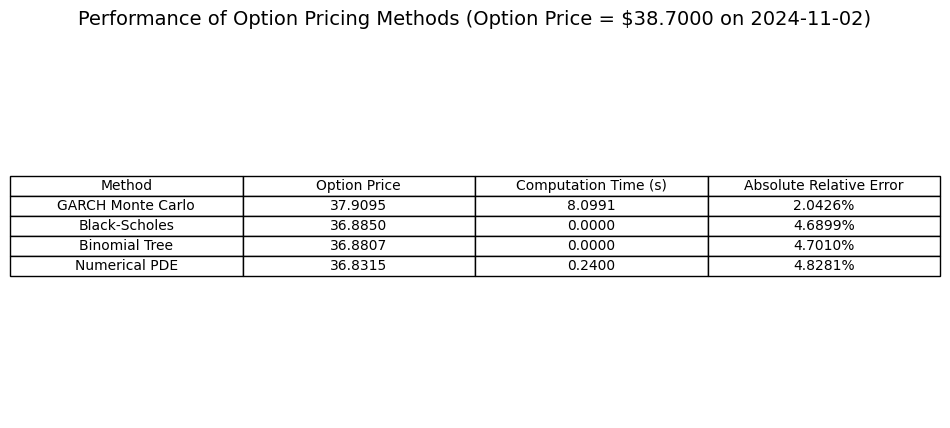

In [ ]:
data = {
    'Method': ['GARCH Monte Carlo','Numerical PDE','Binomial Tree', 'Black-Scholes'],
    'Option Price': [monte_carlo_garch,numerical_pde,binom, bsm],
    'Computation Time (s)': [garch_mc_time,numerical_time,binom_time, bsm_time],
    'Actual Price': [option_price, option_price,option_price,option_price]
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate absolute relative error
df['Absolute Relative Error'] = abs((df['Option Price'] - df['Actual Price']) / df['Actual Price']) * 100  # Convert to percentage

# Sort by absolute relative error
df_sorted = df.sort_values(by='Absolute Relative Error')

# Format columns to keep 4 decimal places
df_sorted['Option Price'] = df_sorted['Option Price'].map('{:.4f}'.format)
df_sorted['Computation Time (s)'] = df_sorted['Computation Time (s)'].map('{:.4f}'.format)
df_sorted['Absolute Relative Error'] = df_sorted['Absolute Relative Error'].map('{:.4f}%'.format)

# Drop the 'Actual Price' column after processing
df_sorted.drop(columns=['Actual Price'], inplace=True)

today_string = today.strftime('%Y-%m-%d')

# Customize title
title = f'Performance of Option Pricing Methods (Option Price = ${option_price:.4f} on {today_string})'

# Plotting the table
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_sorted.values,
                 colLabels=df_sorted.columns,
                 cellLoc='center',
                 loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Scale the table

plt.title(title, fontsize=14)
plt.show()

*   GARCH Monte Carlo
  *   Efficiency & Accuracy<br>
      The GARCH Monte Carlo method is the slowest, likely due to simulating numerous paths and incorporating the GARCH model’s complexity. Even though Monte Carlo simulations can be computationally heavy, implementation details—such as the number of paths, vectorization, or parallelization—could notably reduce computation time. It has the lowest absolute relative error, suggesting high accuracy and a strong fit for modeling real-world volatility behavior. GARCH Monte Carlo adapts to time-varying volatility, providing a closer approximation to the actual price.

  *   Source of Error & Recommendations
      1.   Forecasted Volatility Precision
      *   *Issue:* The non-constant volatility is derived from a GARCH model, but its accuracy depends heavily on how well the model fits historical data. GARCH models, particularly GARCH(1,1), may not fully capture extreme volatility clusters or other complex dependencies in Apple stock price behavior.

      *  *Recommendations:* Test different GARCH model specifications (e.g., GARCH(2,1), EGARCH) to see if they improve forecast accuracy. Additionally, validating the model on out-of-sample data can indicate if the GARCH parameters adequately capture the volatility dynamics.

      2.   Random Sampling Variability
      *   *Issue:* Randomness in the Monte Carlo process introduces variance into the results, meaning the option price estimation may vary significantly between runs.

      *  *Recommendations:* Increase the number of simulations `n_sim` to reduce variance in the option price estimate. However, this comes at the cost of higher computation time. Alternatively, consider variance reduction techniques like antithetic variates or control variates, which can lead to more stable results with fewer simulations.

*   Numerical PDE
  *   Efficiency & Accuracy<br>
      This method offers a good balance between speed and complexity. Numerical PDE methods can vary in efficiency depending on how the grid is implemented and boundary conditions are handled. Further optimization or more refined grid handling could reduce computation time further. The numerical PDE approach is generally robust but might be less precise due to discretization errors, especially if the grid is not sufficiently fine.

  *   Source of Error & Recommendations
      1.   Grid Discretization Error
      *   *Issue:* In the Crank-Nicolson approach, both the time and price grids are discretized. If the grid is too coarse (i.e., `time_steps` and `price_steps` are too low), it may not capture the subtle changes in the option price over time and stock price. This can lead to significant errors, especially for high-volatility assets where the price paths are highly variable.

      *  *Recommendations:* Increase `time_steps` and `price_steps` to reduce the discretization error. Though this will increase computation time, it will improve accuracy, particularly for options with high volatility.

      2.   Choice of `price_range` for Grid Limits
      *   *Issue:* The range chosen for the grid, set as `5 * sigma * sqrt(T)`, may not be sufficient in all cases. A fixed multiplier (e.g., 5) may work well for some volatility levels but could be inadequate for higher-volatility cases where prices have a wider range, introducing truncation error at the boundaries.

      *  *Recommendations:* Dynamically adjust `price_range` based on volatility, with a multiplier that adjusts according to the asset’s recent volatility trends (possibly in the range 4–7 for different volatilities). Testing with a range of multipliers on historical data can help identify an optimal setting that minimizes boundary truncation errors.



*   Binomial Model
  *   Efficiency & Accuracy
      The binomial tree model demonstrates high efficiency, with effectively instantaneous computation time in this implementation. This method benefits from a structured, recursive approach that is relatively simple to compute even for large steps. The binomial tree model’s accuracy is comparable to the numerical PDE method, though slightly better. The error may stem from the model’s inherent assumption of fixed volatility and the discrete approximation.

  *   Source of Error & Recommendations
      1.   Discretization Error
      *   *Issue:* The binomial tree model approximates continuous price movements with discrete time steps. If `N` (number of time steps) is low, this coarse approximation may lead to significant errors, especially near option expiry or for options on highly volatile assets.

      *  *Recommendations:* Increase `N` to reduce discretization error, which will make the model more accurate by providing a finer representation of price paths. However, large values of `N` also increase computation time.

*   BSM Model
  *   Efficiency & Accuracy
      The Black-Scholes model, due to its closed-form solution, is exceptionally fast, yielding near-instantaneous results. This makes it suitable for high-frequency scenarios where time is critical. Black-Scholes is quite comparable to the binomial tree and numerical PDE models, but its assumptions of constant volatility make it less adaptable to real-world scenarios. Nevertheless, for assets with stable volatility, Black-Scholes provides reliable results.

  *   Source of Error & Recommendations
      1.   Volatility Assumption
      *   *Issue:* The BSM model assumes constant volatility, yet volatility in financial markets often varies over time, leading to inaccuracies when pricing options, especially over longer horizons.

      *  *Recommendations:* Use **implied volatility** for calibration, which incorporates the market’s view of expected future volatility and is derived from observed option prices. For more dynamic modeling, consider using a stochastic volatility model, like the Heston model, to capture volatility dynamics over time.

      2.   Interest Rate Assumption
      *   *Issue:* Like volatility, the risk-free rate is assumed to be constant. Interest rates may vary, especially over long-dated options, which can lead to pricing discrepancies.

      *  *Recommendations:* Incorporate a term structure of interest rates for long-dated options, using spot rates or yield curves derived from bond markets to approximate the most accurate rate.




## 3. Variance reduction in Monte Carlo
Assume an Asian-style call option with strike = $250, tenor = 1 years, start date = 2024-10-14. The assumptions are: 1. stock pays no dividend, 2. constant volatility, 3. constant risk-free rate at 5%

In [ ]:
data = yf.download("AAPL", start="2021-10-15", end = "2024-10-14")  #Use data from 2021.10.15 to 2024.10.14
data['Return'] = np.log(1 + data['Adj Close'].pct_change())
data = data.iloc[1:].reset_index(drop=True)
data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
0,144.136368,146.550003,146.839996,143.160004,143.449997,85589200,0.011737
1,146.309967,148.759995,149.169998,146.550003,147.009995,76378900,0.014968
2,146.801743,149.259995,149.750000,148.119995,148.699997,58418800,0.003356
3,147.018127,149.479996,149.639999,147.869995,148.809998,61421000,0.001473
4,146.241119,148.690002,150.179993,148.639999,149.690002,58883400,-0.005299
...,...,...,...,...,...,...,...
746,221.690002,221.690002,225.690002,221.330002,224.500000,39505400,-0.022789
747,225.770004,225.770004,225.979996,223.250000,224.300003,31855700,0.018237
748,229.539993,229.539993,229.750000,224.830002,225.229996,33591100,0.016560


### 3.1. Crude Monte Carlo

In [ ]:
S0 = float(data["Adj Close"].values[-1])
sigma = data['Return'].std()
q = 0
K = 250
T = 252
N = T
r = 0.05 / 252
n_sim = 1000

<ipython-input-68-dc0a676be71a>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S0 = float(data["Adj Close"].values[-1])


In [ ]:
def monte_carlo_asian_call(S, K, r, q, sigma, T, N, n_sim):
    dt = T / N
    ln_S0 = np.log(S)
    nudt = (r - q - 0.5 * sigma**2) * dt
    sigsdt = sigma * np.sqrt(dt)

    total_payoff = 0
    total_payoff_squared = 0

    for i in range(n_sim):
        ln_S = ln_S0
        path_sum = 0

        for i in range(N):
            ln_S += nudt + sigsdt * np.random.randn()
            path_sum += np.exp(ln_S)

        # Calculate payoff for this simulation path
        payoff = np.exp(-r * T) * max((path_sum / N) - K, 0)

        # Update cumulative payoffs and squared payoffs
        total_payoff += payoff
        total_payoff_squared += payoff ** 2

    # Compute option price as the average payoff
    option_price = total_payoff / n_sim

    # Calculate standard error
    variance = (total_payoff_squared - (total_payoff ** 2) / n_sim) * np.exp(-2 * r * T) / (n_sim - 1)
    standard_error = np.sqrt(variance) / np.sqrt(n_sim)

    return option_price, standard_error

# Calculate the Asian call option price and standard error
option_price_MC, standard_error_MC = monte_carlo_asian_call(S0, K, r, q, sigma, T, N, n_sim)
print(f"Asian Option Price: ${option_price_MC:.2f}")
print(f"Standard Error: {standard_error_MC:.4f}")

Asian Option Price: $9.07
Standard Error: 0.5887


### 3.2. Variance Reduction Techniques
Control Variates

In [ ]:
def black_scholes_price(S, K, T, r, q, sigma, call=True):
    d1 = (np.log(S/K) + (r-q+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if call:
        return np.exp(-q*T)*S*norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2)
    else:
        return np.exp(-r*T)*K*norm.cdf(-d2) - np.exp(-q*T)*S*norm.cdf(-d1)

def geom_asian_price(S, K, r, sigma, q, T, N):
    dt = T/N
    nu = r - q - 0.5 * sigma **2
    v = np.exp(-r*T)*S*np.exp((N+1)*nu*dt/2 + (N+1)*(2*N+1)*sigma**2*dt/(12*N))
    sigavg = sigma * np.sqrt(N * (N+1) * (2*N+1) / 6) / (N**1.5)
    return black_scholes_price(v, K, T, r, q, sigavg, call=True)

print('Geometric Asian Option Price: ${:.2f}'.format(geom_asian_price(S0, K, r, sigma, q, T, N)))

Geometric Asian Option Price: $7.54


In [ ]:
def monte_carlo_CV_asian_call(S, K, r, q, sigma, T, N, m, n_sim):
    dt = T / N
    ln_S0 = np.log(S)
    nudt = (r - q - 0.5 * sigma**2) * dt
    sigsdt = sigma * np.sqrt(dt)
    disc = np.exp(-r * T)

    # Calculate phi using the geometric Asian option price as the control variate
    phi = geom_asian_price(S, K, r, sigma, q, T, N)

    # Initialize accumulators for control variate estimation
    sum_x, sum_x2 = 0, 0
    sum_y, sum_y2, sum_xy = 0, 0, 0

    # Estimate beta using m preliminary simulation paths
    for i in range(m):
        ln_S = ln_S0
        sum_prices, sum_ln_S = 0, 0

        for i in range(N):
            ln_S += nudt + sigsdt * np.random.randn()
            sum_prices += np.exp(ln_S)
            sum_ln_S += ln_S

        # Calculate arithmetic and geometric payoffs
        payoff_arith = disc * max((sum_prices / N) - K, 0)
        payoff_geom = disc * max(np.exp(sum_ln_S / N) - K, 0)

        sum_x += payoff_arith
        sum_x2 += payoff_arith**2
        sum_y += payoff_geom
        sum_y2 += payoff_geom**2
        sum_xy += payoff_arith * payoff_geom

    # Compute beta for control variate adjustment
    beta = (m * sum_xy - sum_x * sum_y) / (m * sum_y2 - sum_y**2)

    # Reinitialize accumulators for main simulation
    sum_x, sum_x2 = 0, 0

    # Main simulation with control variate
    for i in range(n_sim):
        ln_S = ln_S0
        sum_prices, sum_ln_S = 0, 0

        for i in range(N):
            ln_S += nudt + sigsdt * np.random.randn()
            sum_prices += np.exp(ln_S)
            sum_ln_S += ln_S

        # Arithmetic and geometric payoffs
        payoff_arith = max((sum_prices / N) - K, 0)
        payoff_geom = max(np.exp(sum_ln_S / N) - K, 0)

        # Adjusted payoff with control variate
        adjusted_payoff = payoff_arith + beta * (phi - payoff_geom)
        sum_x += adjusted_payoff
        sum_x2 += adjusted_payoff**2

    # Final option price and standard error
    option_value = disc * (sum_x / n_sim)
    variance = (sum_x2 - (sum_x**2) / n_sim) * np.exp(-2 * r * T) / (n_sim - 1)
    standard_error = np.sqrt(variance) / np.sqrt(n_sim)

    return option_value, standard_error

# Usage of the Monte Carlo function with control variate
option_price_CV, standard_error_CV = monte_carlo_CV_asian_call(S0, K, r, q, sigma, T, N, m=100, n_sim=1000)
print("Asian Option Price: ${:.2f}".format(option_price_CV))
print("Standard Error: {:.4f}".format(standard_error_CV))

Asian Option Price: $7.82
Standard Error: 0.0323


Antithetic Variates

In [ ]:
def monte_carlo_AV_asian_call(S, K, r, q, sigma, T, N, n_sim):
    dt = T / N
    ln_S0 = np.log(S)
    nudt = (r - q - 0.5 * sigma**2) * dt
    sigsdt = sigma * np.sqrt(dt)

    # Initialize cumulative sums for payoffs and squared payoffs
    sum_payoffs = 0
    sum_payoffs_squared = 0

    for i in range(n_sim):
        ln_S1, ln_S2 = ln_S0, ln_S0
        sum_prices1, sum_prices2 = 0, 0

        for i in range(N):
            z = np.random.randn()
            ln_S1 += nudt + sigsdt * z
            ln_S2 += nudt - sigsdt * z

            sum_prices1 += np.exp(ln_S1)
            sum_prices2 += np.exp(ln_S2)

        # Calculate the payoff for each path
        payoff1 = np.exp(-r * T) * max((sum_prices1 / N) - K, 0)
        payoff2 = np.exp(-r * T) * max((sum_prices2 / N) - K, 0)

        # Use the average of the antithetic pair
        avg_payoff = 0.5 * (payoff1 + payoff2)

        # Update cumulative sums for variance calculation
        sum_payoffs += avg_payoff
        sum_payoffs_squared += avg_payoff ** 2

    # Calculate the option price as the mean of payoffs
    option_price = sum_payoffs / n_sim

    # Estimate standard error of the option price
    variance = (sum_payoffs_squared - (sum_payoffs ** 2) / n_sim) * np.exp(-2 * r * T) / (n_sim - 1)
    standard_error = np.sqrt(variance) / np.sqrt(n_sim)

    return option_price, standard_error

# Calculate the Asian call option price with control variate and standard error
option_price_AV, standard_error_AV = monte_carlo_AV_asian_call(S0, K, r, q, sigma, T, N, n_sim)
print("Asian Option Price: ${:.2f}".format(option_price_AV))
print("Standard Error: {:.4f}".format(standard_error_AV))

Asian Option Price: $7.42
Standard Error: 0.3187


In [ ]:
print("Price with Crude Monte Carlo: ${:.2f}".format(option_price_MC))
print("Price with Monte Carlo with control variate: ${:.2f}".format(option_price_CV))
print("Price with Monte Carlo with antithetic variate: ${:.2f}".format(option_price_AV))
print('\n')
print("Standard error with Crude Monte Carlo: {:.4f}".format(standard_error_MC))
print("Standard error with Monte Carlo with control variate: {:.4f}".format(standard_error_CV))
print("Standard error with Monte Carlo with antithetic variate: {:.4f}".format(standard_error_AV))
print('\n')
print("Efficiency gain with control variates: {:.2f}%".format((standard_error_MC-standard_error_CV)/standard_error_MC))
print("Efficiency gain of antithetic variates: {:.2f}%".format((standard_error_MC-standard_error_AV)/standard_error_MC))

Price with Crude Monte Carlo: $9.07
Price with Monte Carlo with control variate: $7.82
Price with Monte Carlo with antithetic variate: $7.42


Standard error with Crude Monte Carlo: 0.5887
Standard error with Monte Carlo with control variate: 0.0323
Standard error with Monte Carlo with antithetic variate: 0.3187


Efficiency gain with control variates: 0.95%
Efficiency gain of antithetic variates: 0.46%


In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-fre

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!cp drive/MyDrive/Colab\ Notebooks/FN6808_final.ipynb ./

In [ ]:
!jupyter nbconvert --to html "FN6808_final.ipynb"

[NbConvertApp] Converting notebook FN6808_final.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 1521426 bytes to FN6808_final.html


In [ ]:
!ls

drive  FN6808_final.html  FN6808_final.ipynb  sample_data
